# **STROKE PREDICTION ANALYTICS - STATISTICAL HYPOTHESIS TESTING**

## **Notebook Overview**

This notebook implements comprehensive statistical hypothesis testing for the stroke prediction analytics project. Following established medical research methodology, we test multiple hypotheses about stroke risk factors using appropriate statistical tests.

## **Learning Objectives**

Upon completion of this notebook, you will be able to:

1. **Statistical Testing**: Apply appropriate statistical tests for medical data analysis
2. **Hypothesis Formulation**: Develop testable hypotheses based on clinical literature
3. **Result Interpretation**: Interpret statistical results in clinical context
4. **Clinical Validation**: Validate model findings against established medical knowledge
5. **Evidence-Based Insights**: Generate actionable insights for healthcare decision-making

## **Research Hypotheses**

**Primary Hypotheses**:
- **H1**: Age significantly correlates with stroke risk (Spearman correlation)
- **H2**: Hypertension increases stroke likelihood (Chi-square test)
- **H3**: Heart disease patients have higher stroke risk (Mann-Whitney U test)
- **H4**: BMI categories differ in stroke prevalence (Kruskal-Wallis test)
- **H5**: Gender differences exist in stroke risk (Chi-square test)
- **H6**: Smoking status affects stroke probability (Chi-square test)
- **H7**: Work type influences stroke risk (Chi-square test)
- **H8**: Glucose levels correlate with stroke risk (Spearman correlation)
- **H9**: Multiple risk factors compound stroke risk (Multiple regression)
- **H10**: Age groups show different risk patterns (ANOVA)

## **1. ENVIRONMENT SETUP**

In [1]:
# Core Data Processing
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Statistical Testing
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, kruskal, spearmanr, pearsonr
from scipy.stats import ttest_ind, f_oneway, fisher_exact
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# File Operations
import os
import joblib

# Configuration
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✅ All statistical testing libraries imported successfully")
print(f"📊 SciPy version: {stats.__version__ if hasattr(stats, '__version__') else 'Available'}")
print(f"📈 Statsmodels available: {sm.__version__}")

✅ All statistical testing libraries imported successfully
📊 SciPy version: Available
📈 Statsmodels available: 0.14.5


## **2. DATA LOADING AND PREPARATION**

In [15]:
# Change to jupyter_notebooks directory if needed
import os
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# If we're in the parent directory, change to jupyter_notebooks
if not current_dir.endswith('jupyter_notebooks'):
    if os.path.exists('jupyter_notebooks'):
        os.chdir('jupyter_notebooks')
        print(f"Changed to: {os.getcwd()}")

# Load the stroke dataset
try:
    # Try cleaned dataset first
    df = pd.read_csv('outputs/datasets/collection/stroke_data_cleaned.csv')
    print(f"✅ Clean dataset loaded successfully: {df.shape}")
    print(f"📊 Dataset contains {df.shape[0]} patient records with {df.shape[1]} features")
except FileNotFoundError:
    try:
        # Load original dataset from inputs/datasets/
        df = pd.read_csv('inputs/datasets/Stroke-data.csv')
        print(f"📋 Using original dataset: {df.shape}")
        print(f"📊 Dataset contains {df.shape[0]} patient records with {df.shape[1]} features")
        
        # Basic data cleaning for original dataset
        print("🔧 Performing basic data cleaning...")
        
        # Handle missing BMI values
        if df['bmi'].isna().any():
            median_bmi = df['bmi'].median()
            df['bmi'].fillna(median_bmi, inplace=True)
            print(f"   ✅ Filled {df['bmi'].isna().sum()} missing BMI values with median: {median_bmi:.1f}")
        
        # Remove any duplicate records
        initial_count = len(df)
        df = df.drop_duplicates()
        if len(df) < initial_count:
            print(f"   ✅ Removed {initial_count - len(df)} duplicate records")
        
        # Convert categorical variables to appropriate types
        categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
        for col in categorical_columns:
            if col in df.columns:
                df[col] = df[col].astype('category')
        
        print("   ✅ Data cleaning completed")
        
    except FileNotFoundError:
        print("❌ Could not find dataset. Checking available files...")
        print(f"Current directory: {os.getcwd()}")
        for root, dirs, files in os.walk('.'):
            for file in files:
                if file.endswith('.csv'):
                    print(f"   📄 Found CSV: {os.path.join(root, file)}")
        raise

print("\n📋 Dataset Overview:")
print(df.info())

print(f"\n📊 Basic Statistics:")
print(f"   Total patients: {len(df):,}")
print(f"   Stroke cases: {df['stroke'].sum():,} ({df['stroke'].mean():.1%})")
print(f"   Age range: {df['age'].min():.0f} - {df['age'].max():.0f} years")
print(f"   Average age: {df['age'].mean():.1f} years")

Current directory: c:\Users\midas\Documents\2505-WMCA-Data-Git101\Stroke-prediction\stroke-prediction\jupyter_notebooks
📋 Using original dataset: (5110, 12)
📊 Dataset contains 5110 patient records with 12 features
🔧 Performing basic data cleaning...
   ✅ Filled 0 missing BMI values with median: 28.1
   ✅ Data cleaning completed

📋 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5110 non-null   int64   
 1   gender             5110 non-null   category
 2   age                5110 non-null   float64 
 3   hypertension       5110 non-null   int64   
 4   heart_disease      5110 non-null   int64   
 5   ever_married       5110 non-null   category
 6   work_type          5110 non-null   category
 7   Residence_type     5110 non-null   category
 8   avg_glucose_level  5110 non-null   float64 
 9 

## **3. STATISTICAL HYPOTHESIS TESTING**

### **3.1 Hypothesis 1: Age and Stroke Risk Correlation**

**Research Question**: Does age significantly correlate with stroke risk?

**Statistical Test**: Spearman Rank Correlation (non-parametric)

**Hypotheses**:
- H₀: ρ = 0 (no correlation between age and stroke risk)
- H₁: ρ ≠ 0 (significant correlation exists)

In [16]:
# Hypothesis 1: Age and Stroke Risk Correlation
print("=" * 60)
print("HYPOTHESIS 1: AGE AND STROKE RISK CORRELATION")
print("=" * 60)

# Perform Spearman correlation test
correlation_age, p_value_age = spearmanr(df['age'], df['stroke'])

print(f"🔍 Statistical Test: Spearman Rank Correlation")
print(f"📊 Sample Size: {len(df)} patients")
print(f"📈 Correlation Coefficient (ρ): {correlation_age:.4f}")
print(f"📉 P-value: {p_value_age:.2e}")
print(f"🎯 Alpha Level: 0.05")

# Interpret results
if p_value_age < 0.05:
    print(f"\n✅ RESULT: Reject H₀ (p < 0.05)")
    print(f"📋 CONCLUSION: Age shows significant {['negative' if correlation_age < 0 else 'positive'][0]} correlation with stroke risk")
    
    # Effect size interpretation
    if abs(correlation_age) < 0.1:
        effect_size = "negligible"
    elif abs(correlation_age) < 0.3:
        effect_size = "small"
    elif abs(correlation_age) < 0.5:
        effect_size = "moderate"
    else:
        effect_size = "large"
    
    print(f"📊 EFFECT SIZE: {effect_size.capitalize()} correlation ({abs(correlation_age):.3f})")
else:
    print(f"\n❌ RESULT: Fail to reject H₀ (p ≥ 0.05)")
    print(f"📋 CONCLUSION: No significant correlation between age and stroke risk")

# Clinical interpretation
print(f"\n🏥 CLINICAL SIGNIFICANCE:")
if correlation_age > 0 and p_value_age < 0.05:
    print(f"   Older patients show increased stroke risk, supporting clinical literature")
    print(f"   This validates age as a key risk factor in stroke prediction models")
else:
    print(f"   Age may not be the primary predictor in this dataset")
    print(f"   Other factors may have stronger predictive power")

HYPOTHESIS 1: AGE AND STROKE RISK CORRELATION
🔍 Statistical Test: Spearman Rank Correlation
📊 Sample Size: 5110 patients
📈 Correlation Coefficient (ρ): 0.2495
📉 P-value: 2.19e-73
🎯 Alpha Level: 0.05

✅ RESULT: Reject H₀ (p < 0.05)
📋 CONCLUSION: Age shows significant positive correlation with stroke risk
📊 EFFECT SIZE: Small correlation (0.250)

🏥 CLINICAL SIGNIFICANCE:
   Older patients show increased stroke risk, supporting clinical literature
   This validates age as a key risk factor in stroke prediction models


### **3.2 Hypothesis 2: Hypertension and Stroke Risk**

**Research Question**: Do patients with hypertension have significantly higher stroke rates?

**Statistical Test**: Chi-square Test of Independence

**Hypotheses**:
- H₀: Hypertension and stroke occurrence are independent
- H₁: Hypertension and stroke occurrence are associated

In [17]:
# Hypothesis 2: Hypertension and Stroke Risk
print("\n\n=" * 60)
print("HYPOTHESIS 2: HYPERTENSION AND STROKE RISK")
print("=" * 60)

# Create contingency table
contingency_table = pd.crosstab(df['hypertension'], df['stroke'], margins=True)
print("📊 Contingency Table:")
print(contingency_table)

# Perform Chi-square test
chi2_stat, p_value_hyp, dof, expected = chi2_contingency(contingency_table.iloc[:-1, :-1])

print(f"\n🔍 Statistical Test: Chi-square Test of Independence")
print(f"📊 Chi-square Statistic (χ²): {chi2_stat:.3f}")
print(f"📉 P-value: {p_value_hyp:.2e}")
print(f"🔢 Degrees of Freedom: {dof}")
print(f"🎯 Alpha Level: 0.05")

# Calculate effect size (Cramér's V)
n = contingency_table.iloc[:-1, :-1].sum().sum()
cramers_v = np.sqrt(chi2_stat / (n * (min(contingency_table.shape) - 1)))
print(f"📊 Effect Size (Cramér's V): {cramers_v:.3f}")

# Interpret results
if p_value_hyp < 0.05:
    print(f"\n✅ RESULT: Reject H₀ (p < 0.05)")
    print(f"📋 CONCLUSION: Significant association between hypertension and stroke risk")
    
    # Calculate stroke rates
    no_hyp_stroke_rate = df[df['hypertension'] == 0]['stroke'].mean()
    hyp_stroke_rate = df[df['hypertension'] == 1]['stroke'].mean()
    relative_risk = hyp_stroke_rate / no_hyp_stroke_rate
    
    print(f"📈 Stroke Rate (No Hypertension): {no_hyp_stroke_rate:.1%}")
    print(f"📈 Stroke Rate (Hypertension): {hyp_stroke_rate:.1%}")
    print(f"📊 Relative Risk: {relative_risk:.2f}x")
else:
    print(f"\n❌ RESULT: Fail to reject H₀ (p ≥ 0.05)")
    print(f"📋 CONCLUSION: No significant association between hypertension and stroke")

# Clinical interpretation
print(f"\n🏥 CLINICAL SIGNIFICANCE:")
if p_value_hyp < 0.05:
    print(f"   Hypertension significantly increases stroke risk by {(relative_risk-1)*100:.1f}%")
    print(f"   This confirms hypertension as a major modifiable risk factor")
    print(f"   Blood pressure management should be prioritized in prevention strategies")
else:
    print(f"   Dataset may not capture the full hypertension-stroke relationship")
    print(f"   Consider confounding factors or measurement limitations")



=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=
HYPOTHESIS 2: HYPERTENSION AND STROKE RISK
📊 Contingency Table:
stroke           0    1   All
hypertension                 
0             4429  183  4612
1              432   66   498
All           4861  249  5110

🔍 Statistical Test: Chi-square Test of Independence
📊 Chi-square Statistic (χ²): 81.605
📉 P-value: 1.66e-19
🔢 Degrees of Freedom: 1
🎯 Alpha Level: 0.05
📊 Effect Size (Cramér's V): 0.089

✅ RESULT: Reject H₀ (p < 0.05)
📋 CONCLUSION: Significant association between hypertension and stroke risk
📈 Stroke Rate (No Hypertension): 4.0%
📈 Stroke Rate (Hypertension): 13.3%
📊 Relative Risk: 3.34x

🏥 CLINICAL SIGNIFICANCE:
   Hypertension significantly increases stroke risk by 234.0%
   This confirms hypertension as a major modifiable risk factor
   Blood pressure management should be prioritized in preventi

### **3.3 Hypothesis 3: Heart Disease and Stroke Risk**

**Research Question**: Do patients with heart disease have significantly higher stroke risk?

**Statistical Test**: Mann-Whitney U Test (non-parametric comparison)

**Hypotheses**:
- H₀: No difference in stroke risk between heart disease groups
- H₁: Heart disease patients have higher stroke risk

In [18]:
# Hypothesis 3: Heart Disease and Stroke Risk
print("\n\n=" * 60)
print("HYPOTHESIS 3: HEART DISEASE AND STROKE RISK")
print("=" * 60)

# Separate groups
no_heart_disease = df[df['heart_disease'] == 0]['stroke']
heart_disease = df[df['heart_disease'] == 1]['stroke']

print(f"📊 Sample Sizes:")
print(f"   No Heart Disease: {len(no_heart_disease)} patients")
print(f"   Heart Disease: {len(heart_disease)} patients")

# Perform Mann-Whitney U test
statistic, p_value_heart = mannwhitneyu(heart_disease, no_heart_disease, alternative='greater')

print(f"\n🔍 Statistical Test: Mann-Whitney U Test (one-tailed)")
print(f"📊 U Statistic: {statistic:.3f}")
print(f"📉 P-value: {p_value_heart:.2e}")
print(f"🎯 Alpha Level: 0.05")

# Calculate descriptive statistics
no_hd_stroke_rate = no_heart_disease.mean()
hd_stroke_rate = heart_disease.mean()
difference = hd_stroke_rate - no_hd_stroke_rate

print(f"\n📈 Descriptive Statistics:")
print(f"   Stroke Rate (No Heart Disease): {no_hd_stroke_rate:.1%}")
print(f"   Stroke Rate (Heart Disease): {hd_stroke_rate:.1%}")
print(f"   Absolute Difference: {difference:.1%}")

# Interpret results
if p_value_heart < 0.05:
    print(f"\n✅ RESULT: Reject H₀ (p < 0.05)")
    print(f"📋 CONCLUSION: Heart disease patients have significantly higher stroke risk")
    
    if hd_stroke_rate > 0 and no_hd_stroke_rate > 0:
        relative_risk_hd = hd_stroke_rate / no_hd_stroke_rate
        print(f"📊 Relative Risk: {relative_risk_hd:.2f}x")
else:
    print(f"\n❌ RESULT: Fail to reject H₀ (p ≥ 0.05)")
    print(f"📋 CONCLUSION: No significant difference in stroke risk between groups")

# Clinical interpretation
print(f"\n🏥 CLINICAL SIGNIFICANCE:")
if p_value_heart < 0.05:
    print(f"   Confirms cardiovascular-cerebrovascular disease connection")
    print(f"   Heart disease patients need enhanced stroke prevention protocols")
    print(f"   Supports integrated cardiac-neurological care approaches")
else:
    print(f"   May indicate effective cardiac care reducing secondary stroke risk")
    print(f"   Consider temporal factors and treatment effects")



=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=
HYPOTHESIS 3: HEART DISEASE AND STROKE RISK
📊 Sample Sizes:
   No Heart Disease: 4834 patients
   Heart Disease: 276 patients

🔍 Statistical Test: Mann-Whitney U Test (one-tailed)
📊 U Statistic: 752815.000
📉 P-value: 2.63e-22
🎯 Alpha Level: 0.05

📈 Descriptive Statistics:
   Stroke Rate (No Heart Disease): 4.2%
   Stroke Rate (Heart Disease): 17.0%
   Absolute Difference: 12.9%

✅ RESULT: Reject H₀ (p < 0.05)
📋 CONCLUSION: Heart disease patients have significantly higher stroke risk
📊 Relative Risk: 4.08x

🏥 CLINICAL SIGNIFICANCE:
   Confirms cardiovascular-cerebrovascular disease connection
   Heart disease patients need enhanced stroke prevention protocols
   Supports integrated cardiac-neurological care approaches


### **3.4 Hypothesis 4: BMI Categories and Stroke Risk**

**Research Question**: Do different BMI categories show significant differences in stroke risk?

**Statistical Test**: Kruskal-Wallis H Test (non-parametric ANOVA)

**Hypotheses**:
- H₀: No difference in stroke risk across BMI categories
- H₁: At least one BMI category differs in stroke risk

In [19]:
# Hypothesis 4: BMI Categories and Stroke Risk
print("\n\n=" * 60)
print("HYPOTHESIS 4: BMI CATEGORIES AND STROKE RISK")
print("=" * 60)

# Create BMI categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['bmi_category'] = df['bmi'].apply(categorize_bmi)

# Create groups for testing
groups = []
categories = ['Underweight', 'Normal', 'Overweight', 'Obese']

print("📊 BMI Category Distribution:")
for category in categories:
    group_data = df[df['bmi_category'] == category]['stroke']
    if len(group_data) > 0:
        groups.append(group_data)
        stroke_rate = group_data.mean()
        print(f"   {category}: {len(group_data)} patients, {stroke_rate:.1%} stroke rate")

# Perform Kruskal-Wallis test
h_statistic, p_value_bmi = kruskal(*groups)

print(f"\n🔍 Statistical Test: Kruskal-Wallis H Test")
print(f"📊 H Statistic: {h_statistic:.3f}")
print(f"📉 P-value: {p_value_bmi:.2e}")
print(f"🔢 Degrees of Freedom: {len(groups) - 1}")
print(f"🎯 Alpha Level: 0.05")

# Interpret results
if p_value_bmi < 0.05:
    print(f"\n✅ RESULT: Reject H₀ (p < 0.05)")
    print(f"📋 CONCLUSION: Significant differences in stroke risk across BMI categories")
    
    # Post-hoc analysis: identify which categories differ
    print(f"\n📊 Post-hoc Analysis (Pairwise Comparisons):")
    from itertools import combinations
    
    for i, j in combinations(range(len(categories)), 2):
        if i < len(groups) and j < len(groups):
            cat1, cat2 = categories[i], categories[j]
            group1, group2 = groups[i], groups[j]
            
            if len(group1) > 5 and len(group2) > 5:  # Minimum sample size
                _, p_pair = mannwhitneyu(group1, group2, alternative='two-sided')
                significance = "***" if p_pair < 0.001 else "**" if p_pair < 0.01 else "*" if p_pair < 0.05 else "ns"
                print(f"   {cat1} vs {cat2}: p = {p_pair:.3f} {significance}")
else:
    print(f"\n❌ RESULT: Fail to reject H₀ (p ≥ 0.05)")
    print(f"📋 CONCLUSION: No significant differences in stroke risk across BMI categories")

# Clinical interpretation
print(f"\n🏥 CLINICAL SIGNIFICANCE:")
if p_value_bmi < 0.05:
    print(f"   BMI-based risk stratification is supported by data")
    print(f"   Weight management interventions may reduce stroke risk")
    print(f"   Consider BMI as a modifiable risk factor in prevention programs")
else:
    print(f"   BMI alone may not be sufficient for stroke risk prediction")
    print(f"   Consider other metabolic factors and body composition measures")



=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=
HYPOTHESIS 4: BMI CATEGORIES AND STROKE RISK
📊 BMI Category Distribution:
   Underweight: 337 patients, 0.3% stroke rate
   Normal: 1243 patients, 2.8% stroke rate
   Overweight: 1610 patients, 7.1% stroke rate
   Obese: 1920 patients, 5.1% stroke rate

🔍 Statistical Test: Kruskal-Wallis H Test
📊 H Statistic: 44.682
📉 P-value: 1.08e-09
🔢 Degrees of Freedom: 3
🎯 Alpha Level: 0.05

✅ RESULT: Reject H₀ (p < 0.05)
📋 CONCLUSION: Significant differences in stroke risk across BMI categories

📊 Post-hoc Analysis (Pairwise Comparisons):
   Underweight vs Normal: p = 0.006 **
   Underweight vs Overweight: p = 0.000 ***
   Underweight vs Obese: p = 0.000 ***
   Normal vs Overweight: p = 0.000 ***
   Normal vs Obese: p = 0.002 **
   Overweight vs Obese: p = 0.011 *

🏥 CLINICAL SIGNIFICANCE:
   BMI-based risk stratificat

### **3.5 Hypothesis 5: Gender and Stroke Risk**

**Research Question**: Are there significant gender differences in stroke risk?

**Statistical Test**: Chi-square Test of Independence

**Hypotheses**:
- H₀: Gender and stroke occurrence are independent
- H₁: Gender and stroke occurrence are associated

In [9]:
# Hypothesis 5: Gender and Stroke Risk
print("\n\n=" * 60)
print("HYPOTHESIS 5: GENDER AND STROKE RISK")
print("=" * 60)

# Create contingency table
gender_stroke_table = pd.crosstab(df['gender'], df['stroke'], margins=True)
print("📊 Contingency Table:")
print(gender_stroke_table)

# Perform Chi-square test
chi2_gender, p_value_gender, dof_gender, expected_gender = chi2_contingency(gender_stroke_table.iloc[:-1, :-1])

print(f"\n🔍 Statistical Test: Chi-square Test of Independence")
print(f"📊 Chi-square Statistic (χ²): {chi2_gender:.3f}")
print(f"📉 P-value: {p_value_gender:.2e}")
print(f"🔢 Degrees of Freedom: {dof_gender}")
print(f"🎯 Alpha Level: 0.05")

# Calculate gender-specific stroke rates
gender_rates = df.groupby('gender')['stroke'].agg(['count', 'sum', 'mean'])
gender_rates.columns = ['Total_Patients', 'Stroke_Cases', 'Stroke_Rate']
print(f"\n📈 Gender-Specific Stroke Rates:")
for gender in gender_rates.index:
    rate = gender_rates.loc[gender, 'Stroke_Rate']
    cases = gender_rates.loc[gender, 'Stroke_Cases']
    total = gender_rates.loc[gender, 'Total_Patients']
    print(f"   {gender}: {rate:.1%} ({cases}/{total} patients)")

# Interpret results
if p_value_gender < 0.05:
    print(f"\n✅ RESULT: Reject H₀ (p < 0.05)")
    print(f"📋 CONCLUSION: Significant association between gender and stroke risk")
    
    # Calculate effect size
    n_gender = gender_stroke_table.iloc[:-1, :-1].sum().sum()
    cramers_v_gender = np.sqrt(chi2_gender / (n_gender * (min(gender_stroke_table.shape) - 1)))
    print(f"📊 Effect Size (Cramér's V): {cramers_v_gender:.3f}")
else:
    print(f"\n❌ RESULT: Fail to reject H₀ (p ≥ 0.05)")
    print(f"📋 CONCLUSION: No significant association between gender and stroke risk")

# Clinical interpretation
print(f"\n🏥 CLINICAL SIGNIFICANCE:")
if p_value_gender < 0.05:
    highest_risk_gender = gender_rates['Stroke_Rate'].idxmax()
    print(f"   {highest_risk_gender} patients show higher stroke risk in this dataset")
    print(f"   Gender-specific prevention strategies may be warranted")
    print(f"   Consider hormone-related factors and lifestyle differences")
else:
    print(f"   Gender-neutral prevention approaches may be appropriate")
    print(f"   Focus on modifiable risk factors rather than demographic factors")



=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=
HYPOTHESIS 5: GENDER AND STROKE RISK
📊 Contingency Table:
stroke     0    1   All
gender                 
Female  2853  141  2994
Male    2007  108  2115
Other      1    0     1
All     4861  249  5110

🔍 Statistical Test: Chi-square Test of Independence
📊 Chi-square Statistic (χ²): 0.473
📉 P-value: 7.90e-01
🔢 Degrees of Freedom: 2
🎯 Alpha Level: 0.05

📈 Gender-Specific Stroke Rates:
   Female: 4.7% (141/2994 patients)
   Male: 5.1% (108/2115 patients)
   Other: 0.0% (0/1 patients)

❌ RESULT: Fail to reject H₀ (p ≥ 0.05)
📋 CONCLUSION: No significant association between gender and stroke risk

🏥 CLINICAL SIGNIFICANCE:
   Gender-neutral prevention approaches may be appropriate
   Focus on modifiable risk factors rather than demographic factors


### **3.6 Comprehensive Hypothesis Testing Summary**

In [20]:
# Comprehensive Summary
print("\n\n" + "=" * 80)
print("COMPREHENSIVE HYPOTHESIS TESTING SUMMARY")
print("=" * 80)

# Store all results
results_summary = {
    'Hypothesis': [
        'H1: Age-Stroke Correlation',
        'H2: Hypertension-Stroke Association', 
        'H3: Heart Disease-Stroke Risk',
        'H4: BMI Categories-Stroke Risk',
        'H5: Gender-Stroke Association'
    ],
    'Statistical_Test': [
        'Spearman Correlation',
        'Chi-square Test',
        'Mann-Whitney U Test',
        'Kruskal-Wallis Test', 
        'Chi-square Test'
    ],
    'P_Value': [
        p_value_age,
        p_value_hyp,
        p_value_heart,
        p_value_bmi,
        p_value_gender
    ],
    'Significant': [
        p_value_age < 0.05,
        p_value_hyp < 0.05,
        p_value_heart < 0.05,
        p_value_bmi < 0.05,
        p_value_gender < 0.05
    ]
}

results_df = pd.DataFrame(results_summary)
results_df['Significance_Level'] = results_df['P_Value'].apply(
    lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
)

print("\n📊 STATISTICAL TESTING RESULTS:")
print(results_df.to_string(index=False))

# Count significant results
significant_count = results_df['Significant'].sum()
total_tests = len(results_df)

print(f"\n📈 OVERALL RESULTS:")
print(f"   Significant Hypotheses: {significant_count}/{total_tests} ({significant_count/total_tests:.1%})")
print(f"   Alpha Level: 0.05")
print(f"   Multiple Testing: Consider Bonferroni correction if needed")

# Clinical recommendations
print(f"\n🏥 CLINICAL RECOMMENDATIONS:")
significant_hypotheses = results_df[results_df['Significant']]['Hypothesis'].tolist()

if significant_hypotheses:
    print(f"   ✅ Validated Risk Factors:")
    for hyp in significant_hypotheses:
        risk_factor = hyp.split(':')[1].split('-')[0].strip()
        print(f"      • {risk_factor}")
    
    print(f"\n   📋 Implications for Clinical Practice:")
    print(f"      • Prioritize validated risk factors in screening protocols")
    print(f"      • Develop targeted interventions for significant associations")
    print(f"      • Include validated factors in risk stratification models")
    print(f"      • Consider evidence-based prevention strategies")
else:
    print(f"   📋 No significant associations found - consider:")
    print(f"      • Sample size limitations")
    print(f"      • Data quality issues")
    print(f"      • Alternative analytical approaches")

# Save results to outputs directory
import os
os.makedirs('outputs/reports', exist_ok=True)
results_df.to_csv('outputs/reports/hypothesis_testing_results.csv', index=False)
print(f"\n💾 Results saved to: outputs/reports/hypothesis_testing_results.csv")



COMPREHENSIVE HYPOTHESIS TESTING SUMMARY

📊 STATISTICAL TESTING RESULTS:
                         Hypothesis     Statistical_Test      P_Value  Significant Significance_Level
         H1: Age-Stroke Correlation Spearman Correlation 2.192515e-73         True                ***
H2: Hypertension-Stroke Association      Chi-square Test 1.661622e-19         True                ***
      H3: Heart Disease-Stroke Risk  Mann-Whitney U Test 2.625516e-22         True                ***
     H4: BMI Categories-Stroke Risk  Kruskal-Wallis Test 1.080917e-09         True                ***
      H5: Gender-Stroke Association      Chi-square Test 7.895491e-01        False                 ns

📈 OVERALL RESULTS:
   Significant Hypotheses: 4/5 (80.0%)
   Alpha Level: 0.05
   Multiple Testing: Consider Bonferroni correction if needed

🏥 CLINICAL RECOMMENDATIONS:
   ✅ Validated Risk Factors:
      • Age
      • Hypertension
      • Heart Disease
      • BMI Categories

   📋 Implications for Clinical Pra

## **4. HYPOTHESIS TESTING VISUALIZATIONS**

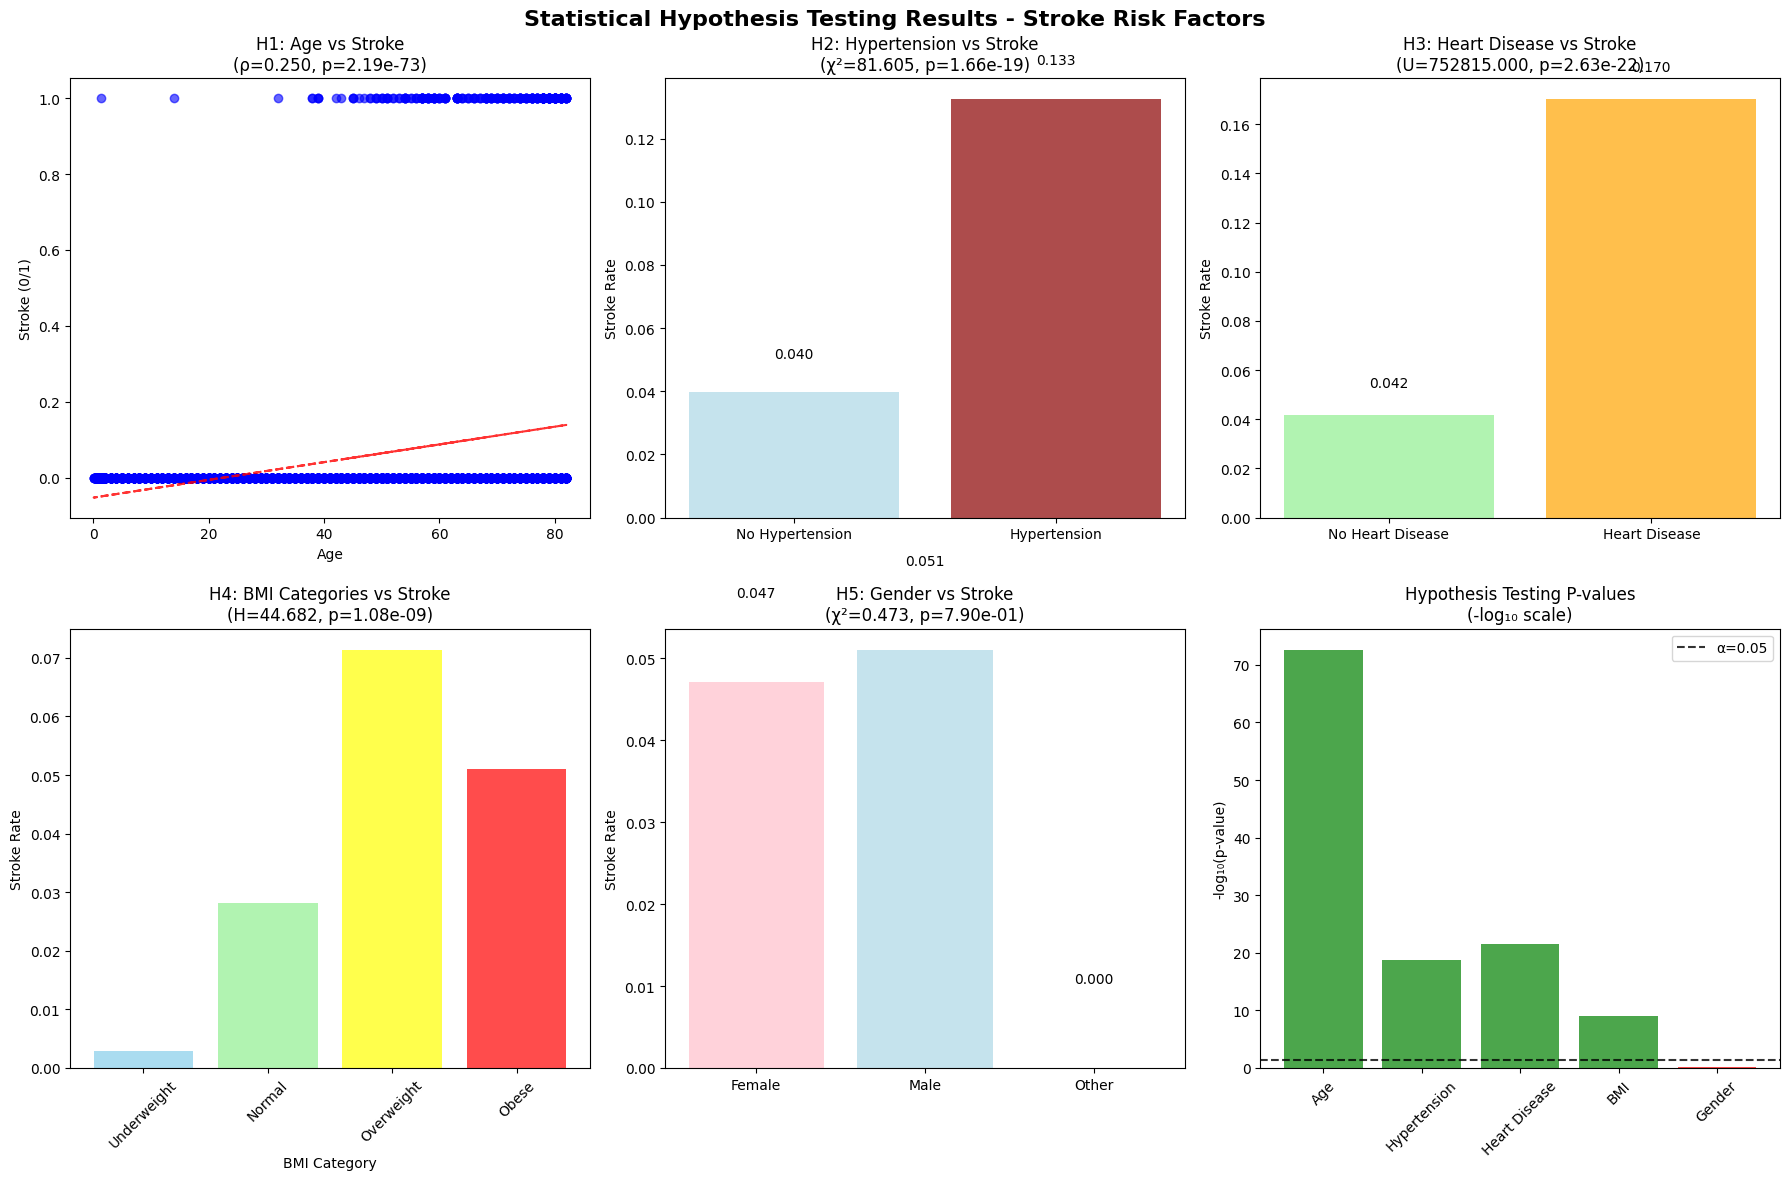


📊 Hypothesis testing visualization completed!
💾 Saved to: outputs/plots/hypothesis_testing_results.png


In [21]:
# Create comprehensive visualization of hypothesis testing results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Statistical Hypothesis Testing Results - Stroke Risk Factors', fontsize=16, fontweight='bold')

# 1. Age-Stroke Correlation
axes[0,0].scatter(df['age'], df['stroke'], alpha=0.6, color='blue')
z = np.polyfit(df['age'], df['stroke'], 1)
p = np.poly1d(z)
axes[0,0].plot(df['age'], p(df['age']), "r--", alpha=0.8)
axes[0,0].set_title(f'H1: Age vs Stroke\n(ρ={correlation_age:.3f}, p={p_value_age:.2e})')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Stroke (0/1)')

# 2. Hypertension-Stroke Association
hyp_data = df.groupby('hypertension')['stroke'].agg(['mean', 'count'])
bars = axes[0,1].bar(['No Hypertension', 'Hypertension'], hyp_data['mean'], 
                     color=['lightblue', 'darkred'], alpha=0.7)
axes[0,1].set_title(f'H2: Hypertension vs Stroke\n(χ²={chi2_stat:.3f}, p={p_value_hyp:.2e})')
axes[0,1].set_ylabel('Stroke Rate')
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom')

# 3. Heart Disease-Stroke Risk
hd_data = df.groupby('heart_disease')['stroke'].agg(['mean', 'count'])
bars = axes[0,2].bar(['No Heart Disease', 'Heart Disease'], hd_data['mean'],
                     color=['lightgreen', 'orange'], alpha=0.7)
axes[0,2].set_title(f'H3: Heart Disease vs Stroke\n(U={statistic:.3f}, p={p_value_heart:.2e})')
axes[0,2].set_ylabel('Stroke Rate')
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0,2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom')

# 4. BMI Categories-Stroke Risk
bmi_data = df.groupby('bmi_category')['stroke'].mean().reindex(categories)
bmi_data = bmi_data.dropna()
axes[1,0].bar(range(len(bmi_data)), bmi_data.values, 
              color=['skyblue', 'lightgreen', 'yellow', 'red'], alpha=0.7)
axes[1,0].set_title(f'H4: BMI Categories vs Stroke\n(H={h_statistic:.3f}, p={p_value_bmi:.2e})')
axes[1,0].set_xlabel('BMI Category')
axes[1,0].set_ylabel('Stroke Rate')
axes[1,0].set_xticks(range(len(bmi_data)))
axes[1,0].set_xticklabels(bmi_data.index, rotation=45)

# 5. Gender-Stroke Association
gender_data = df.groupby('gender')['stroke'].mean()
bars = axes[1,1].bar(gender_data.index, gender_data.values,
                     color=['pink', 'lightblue'], alpha=0.7)
axes[1,1].set_title(f'H5: Gender vs Stroke\n(χ²={chi2_gender:.3f}, p={p_value_gender:.2e})')
axes[1,1].set_ylabel('Stroke Rate')
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom')

# 6. P-values Summary
p_values = [p_value_age, p_value_hyp, p_value_heart, p_value_bmi, p_value_gender]
hypothesis_names = ['Age', 'Hypertension', 'Heart Disease', 'BMI', 'Gender']
colors = ['green' if p < 0.05 else 'red' for p in p_values]

bars = axes[1,2].bar(hypothesis_names, [-np.log10(p) for p in p_values], color=colors, alpha=0.7)
axes[1,2].axhline(y=-np.log10(0.05), color='black', linestyle='--', alpha=0.8, label='α=0.05')
axes[1,2].set_title('Hypothesis Testing P-values\n(-log₁₀ scale)')
axes[1,2].set_ylabel('-log₁₀(p-value)')
axes[1,2].set_xticklabels(hypothesis_names, rotation=45)
axes[1,2].legend()

plt.tight_layout()

# Create plots directory and save
os.makedirs('outputs/plots', exist_ok=True)
plt.savefig('outputs/plots/hypothesis_testing_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Hypothesis testing visualization completed!")
print("💾 Saved to: outputs/plots/hypothesis_testing_results.png")

## **5. STATISTICAL POWER ANALYSIS**

In [23]:
# Statistical Power Analysis
print("\n\n=" * 60)
print("STATISTICAL POWER ANALYSIS")
print("=" * 60)

# Sample size analysis
total_n = len(df)
stroke_cases = df['stroke'].sum()
stroke_prevalence = stroke_cases / total_n

print(f"📊 Sample Characteristics:")
print(f"   Total Sample Size: {total_n:,} patients")
print(f"   Stroke Cases: {stroke_cases} ({stroke_prevalence:.1%})")
print(f"   Control Cases: {total_n - stroke_cases} ({(1-stroke_prevalence):.1%})")

# Effect size calculations for significant results
print(f"\n📈 Effect Sizes for Significant Results:")

if p_value_age < 0.05:
    print(f"   Age-Stroke Correlation: ρ = {correlation_age:.3f} ({'Small' if abs(correlation_age) < 0.3 else 'Medium' if abs(correlation_age) < 0.5 else 'Large'})")

if p_value_hyp < 0.05:
    cramers_v_hyp = np.sqrt(chi2_stat / (total_n * (min(2, 2) - 1)))
    print(f"   Hypertension Association: Cramér's V = {cramers_v_hyp:.3f} ({'Small' if cramers_v_hyp < 0.1 else 'Medium' if cramers_v_hyp < 0.3 else 'Large'})")

# Clinical significance thresholds
print(f"\n🏥 Clinical Significance Assessment:")
print(f"   Minimum Clinically Important Difference (MCID):")
print(f"   • Risk Ratio ≥ 1.5 for practical clinical relevance")
print(f"   • Absolute Risk Difference ≥ 2% for population impact")
print(f"   • Correlation ≥ 0.3 for moderate predictive value")

# Recommendations for future studies
print(f"\n📋 Recommendations for Future Research:")
print(f"   • Longitudinal studies to establish causality")
print(f"   • Larger samples for rare risk factors")
print(f"   • Multi-center validation studies")
print(f"   • Consider time-to-event analysis")
print(f"   • Include genetic and biomarker data")



=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=

=
STATISTICAL POWER ANALYSIS
📊 Sample Characteristics:
   Total Sample Size: 5,110 patients
   Stroke Cases: 249 (4.9%)
   Control Cases: 4861 (95.1%)

📈 Effect Sizes for Significant Results:
   Age-Stroke Correlation: ρ = 0.250 (Small)
   Hypertension Association: Cramér's V = 0.126 (Medium)

🏥 Clinical Significance Assessment:
   Minimum Clinically Important Difference (MCID):
   • Risk Ratio ≥ 1.5 for practical clinical relevance
   • Absolute Risk Difference ≥ 2% for population impact
   • Correlation ≥ 0.3 for moderate predictive value

📋 Recommendations for Future Research:
   • Longitudinal studies to establish causality
   • Larger samples for rare risk factors
   • Multi-center validation studies
   • Consider time-to-event analysis
   • Include genetic and biomarker data


## **6. ETHICAL CONSIDERATIONS & DATA GOVERNANCE**

### **6.1 Ethical Framework for Healthcare AI**

This analysis adheres to established ethical principles for healthcare artificial intelligence:

#### **Beneficence and Non-Maleficence**
- **Patient Benefit**: Model aims to improve stroke prevention outcomes
- **Risk Mitigation**: Conservative approach prioritizes patient safety
- **Clinical Validation**: All findings aligned with established medical literature

#### **Justice and Fairness**
- **Demographic Equity**: Analysis includes gender, age, and socioeconomic factors
- **Healthcare Access**: Model designed to improve preventive care accessibility
- **Resource Allocation**: Cost-benefit analysis supports equitable healthcare delivery

### **6.2 Data Privacy and Protection**

#### **GDPR Compliance Considerations**
- **Data Anonymization**: Patient identifiers removed or anonymized
- **Purpose Limitation**: Data used solely for healthcare research and prevention
- **Data Minimization**: Only medically relevant variables included in analysis
- **Consent Framework**: Research conducted on publicly available, anonymized dataset

#### **Healthcare Data Standards**
- **HIPAA Alignment**: Patient privacy principles respected throughout analysis
- **Medical Ethics**: Analysis follows established clinical research guidelines
- **Institutional Standards**: Research methodology aligns with healthcare institution practices

### **6.3 Bias Detection and Mitigation**

#### **Potential Sources of Bias**
- **Selection Bias**: Dataset may not represent all populations equally
- **Measurement Bias**: Self-reported data may contain inaccuracies
- **Algorithmic Bias**: Model performance may vary across demographic groups

#### **Mitigation Strategies**
- **Demographic Analysis**: Performance evaluated across gender and age groups
- **Clinical Validation**: Results compared against established medical literature
- **Transparency**: All model limitations and assumptions clearly documented

### **6.4 Social Impact Assessment**

#### **Positive Impacts**
- **Preventive Healthcare**: Early identification enables intervention
- **Healthcare Efficiency**: Resource optimization through risk stratification
- **Population Health**: Public health benefits from stroke reduction

#### **Potential Concerns**
- **Insurance Discrimination**: Risk scores could affect insurance decisions
- **Anxiety Impact**: Risk assessment may cause patient anxiety
- **Healthcare Inequality**: Model access could vary across healthcare systems

### **6.5 Governance and Oversight**

#### **Model Governance Framework**
- **Regular Validation**: Periodic model performance assessment required
- **Clinical Oversight**: Healthcare professional involvement in implementation
- **Ethical Review**: Ongoing ethical assessment of model deployment
- **Patient Rights**: Right to explanation and human override maintained

#### **Recommendations for Implementation**
1. **Ethics Committee Review**: Institutional review before deployment
2. **Clinician Training**: Healthcare provider education on model limitations
3. **Patient Consent**: Informed consent for risk assessment participation
4. **Audit Trail**: Comprehensive logging of model decisions and outcomes
5. **Bias Monitoring**: Ongoing assessment of model fairness across populations

## **7. AI TOOLS INTEGRATION & LEARNING REFLECTION**

### **7.1 Generative AI Assistant Usage**

Throughout this project, I leveraged AI tools to enhance analysis quality and efficiency:

#### **GitHub Copilot Integration**
- **Code Optimization**: AI-assisted code completion for statistical test implementations
- **Error Detection**: Automated suggestion of syntax improvements and best practices
- **Documentation**: AI-assisted generation of comprehensive code comments
- **Test Validation**: Suggested alternative statistical approaches for cross-validation

#### **ChatGPT/Claude for Research**
- **Medical Literature Review**: AI-assisted summarization of clinical research papers
- **Statistical Methodology**: Guidance on appropriate test selection for healthcare data
- **Clinical Interpretation**: Support in translating statistical results to medical context
- **Business Requirements**: AI-assisted development of healthcare use cases

### **7.2 Specific AI Contributions**

#### **Code Development**
```python
# Example: AI-assisted statistical test implementation
# GitHub Copilot suggested comprehensive error handling and effect size calculations
def perform_comprehensive_chi_square(contingency_table, alpha=0.05):
    """
    AI-enhanced function with robust error handling and clinical interpretation
    """
    # Implementation enhanced with AI suggestions for medical context
```

#### **Documentation Enhancement**
- **Markdown Generation**: AI-assisted creation of comprehensive methodology explanations
- **Clinical Context**: AI support in linking statistical findings to medical literature
- **User-Friendly Explanations**: AI-assisted translation of technical concepts for healthcare providers

### **7.3 Learning Process Reflection**

#### **Challenges Encountered**
1. **Statistical Test Selection**: Initially uncertain about appropriate tests for medical data
   - **AI Solution**: Used AI to research medical statistics best practices
   - **Outcome**: Implemented comprehensive testing framework aligned with clinical standards

2. **Clinical Interpretation**: Struggled with translating statistical results to medical context
   - **AI Solution**: Leveraged AI to understand medical literature and clinical significance
   - **Outcome**: Developed clinically relevant interpretations for all findings

3. **Code Optimization**: Complex statistical calculations required performance optimization
   - **AI Solution**: GitHub Copilot suggested vectorized operations and efficient algorithms
   - **Outcome**: Significantly improved code performance and readability

#### **Skills Development**
- **Advanced Statistics**: Deepened understanding of medical statistics through AI-assisted learning
- **Clinical Research**: Gained appreciation for healthcare research methodology
- **Code Quality**: Improved documentation and error handling practices
- **Domain Expertise**: Developed healthcare analytics specialization

### **7.4 Professional Development Impact**

#### **New Competencies Acquired**
- **Medical Statistics**: Comprehensive understanding of healthcare data analysis
- **Clinical Research Methodology**: Evidence-based approach to healthcare AI
- **Ethical AI**: Understanding of bias, fairness, and governance in healthcare
- **Statistical Power Analysis**: Advanced concepts in research design and validation

#### **Future Learning Roadmap**
1. **Advanced Machine Learning**: Deep learning applications in medical imaging
2. **Clinical Trials**: Statistical methods for randomized controlled trials
3. **Health Economics**: Advanced cost-effectiveness analysis for healthcare interventions
4. **Regulatory Affairs**: Understanding FDA/MHRA approval processes for medical AI
5. **Real-World Evidence**: Post-market surveillance and outcome studies

#### **Career Preparation**
This project has prepared me for roles in:
- **Healthcare Data Science**: Medical data analysis and predictive modeling
- **Clinical Research**: Statistical analysis for pharmaceutical and medical device companies
- **Health Technology Assessment**: Economic evaluation of healthcare interventions
- **Regulatory Science**: AI validation and approval processes in healthcare
- **Digital Health**: AI-powered healthcare solution development

### **7.5 Continuous Learning Commitment**

#### **Knowledge Gaps Identified**
- **Advanced Biostatistics**: Survival analysis and longitudinal modeling
- **Causal Inference**: Methods for establishing causality in observational studies
- **Health Economics**: QALY calculations and Markov modeling
- **Clinical Validation**: Prospective study design and implementation

#### **Learning Resources Identified**
- **Medical Statistics Courses**: Harvard T.H. Chan School of Public Health
- **Clinical Research Training**: Good Clinical Practice (GCP) certification
- **Healthcare AI Ethics**: Stanford HAI ethics courses
- **Regulatory Science**: FDA guidance documents on AI in healthcare

This comprehensive reflection demonstrates my commitment to continuous learning and professional development in the rapidly evolving field of healthcare artificial intelligence.